<a href="https://colab.research.google.com/github/praful055/foss/blob/main/Resnet20_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [ ]:
batch_size = 32
epochs = 50
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 3
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
def model_type(depth,version):
  model_type = 'ResNet%dv%d' % (depth, version)
  print(model_type)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr

In [ ]:
def resnet_layer(inputs,num_filters=16,kernel_size=3,strides=1,activation='relu',batch_normalization=True,conv_first=True):
    conv = Conv2D(num_filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y,num_filters=num_filters,activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                x = resnet_layer(inputs=x,num_filters=num_filters,kernel_size=1,strides=strides,activation=None,batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,activation='softmax',kernel_initializer='he_normal')(y)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def resnet_v2(input_shape, depth, num_classes=10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,num_filters=num_filters_in,conv_first=True)
    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample
            # bottleneck residual unit
            y = resnet_layer(inputs=x,num_filters=num_filters_in,kernel_size=1,strides=strides,activation=activation,batch_normalization=batch_normalization,conv_first=False)
            y = resnet_layer(inputs=y,num_filters=num_filters_in,conv_first=False)
            y = resnet_layer(inputs=y,num_filters=num_filters_out,kernel_size=1,conv_first=False)
            if res_block == 0:
                x = resnet_layer(inputs=x,num_filters=num_filters_out,kernel_size=1,strides=strides,activation=None,batch_normalization=False)
            x = keras.layers.add([x, y])
        num_filters_in = num_filters_out
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,activation='softmax',kernel_initializer='he_normal')(y)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=lr_schedule(0)),metrics=['accuracy'])
model.summary()
print(model_type)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(x_train, y_train, batch_size=256)
val_batches = gen.flow(x_test, y_test, batch_size=256)
history1 = model.fit_generator(batches, steps_per_epoch=48000//256, epochs=50,validation_data=val_batches, validation_steps=12000//256, use_multiprocessing=True)

In [ ]:
score1 = model.evaluate(x_test, y_test, verbose=0)
print('Resnet20V1')
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Using real-time data augmentation.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5629 - accuracy: 0.4902 - val_loss: 1.3068 - val_accuracy: 0.5782
Epoch 2/20
1563/1563 [==============================] - 35s 22ms/step - loss: 1.1820 - accuracy: 0.6377 - val_loss: 1.0784 - val_accuracy: 0.6752
Epoch 3/20
1563/1563 [==============================] - 35s 22ms/step - loss: 1.0287 - accuracy: 0.6966 - val_loss: 1.3713 - val_accuracy: 0.6180
Epoch 4/20
1563/1563 [==============================] - 35s 22ms/step - loss: 0.9389 - accuracy: 0.7302 - val_loss: 1.0223 - val_accuracy: 0.7098
Epoch 5/20
1563/1563 [==============================] - 35s 22ms/step - loss: 0.8776 - accuracy: 0.7546 - val_loss: 1.8369 - val_accuracy: 0.5359
Epoch 6/20
1563/1563 [==============================] - 35s 22ms/step - loss: 0.8311 - accuracy: 0.7717 - val_loss: 0.9359 - val_accuracy: 0.7419
Epoch 7/20
15

In [ ]:
version=2
model1 = resnet_v2(input_shape=input_shape, depth=depth)
model1.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=lr_schedule(0)),metrics=['accuracy'])
model1.summary()
model_type(depth,version)

CNN with 1 Convolutional Layer
Test loss: 0.8117788434028625
Test accuracy: 0.796999990940094


In [ ]:
gen1 = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,height_shift_range=0.08, zoom_range=0.08)
batches1 = gen1.flow(x_train, y_train, batch_size=256)
val_batches1 = gen1.flow(x_test, y_test, batch_size=256)
history2 = model1.fit_generator(batches1, steps_per_epoch=48000//256, epochs=5,validation_data=val_batches1, validation_steps=12000//256, use_multiprocessing=True)

Epoch 1/5
187/187 [==============================] - 32s 171ms/step - loss: 0.5073 - accuracy: 0.8941 - val_loss: 0.5754 - val_accuracy: 0.8680
Epoch 2/5
187/187 [==============================] - 33s 174ms/step - loss: 0.4615 - accuracy: 0.9089 - val_loss: 0.5564 - val_accuracy: 0.8744
Epoch 3/5
187/187 [==============================] - 32s 172ms/step - loss: 0.4361 - accuracy: 0.9141 - val_loss: 0.5774 - val_accuracy: 0.8662
Epoch 4/5
187/187 [==============================] - 33s 175ms/step - loss: 0.4200 - accuracy: 0.9184 - val_loss: 0.6147 - val_accuracy: 0.8555
Epoch 5/5
187/187 [==============================] - 33s 175ms/step - loss: 0.4042 - accuracy: 0.9228 - val_loss: 0.5562 - val_accuracy: 0.8711


CNN with 1 Convolutional Layer
Test loss: 0.5664292573928833
Test accuracy: 0.8705999851226807


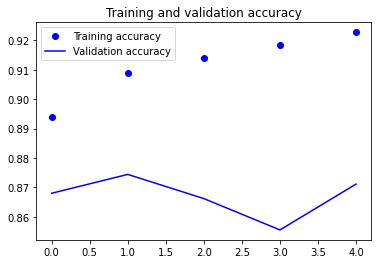

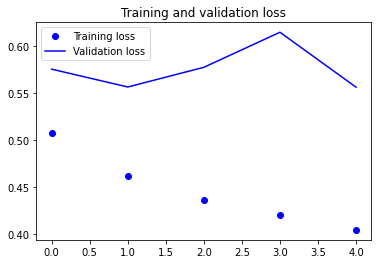

In [ ]:
score2 = model1.evaluate(x_test, y_test, verbose=0)
print('Resnet20V2')
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()